<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/S12_TinyImageNet_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-04-18 19:47:52.108803


In [2]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/tiny-imagenet-200.zip"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
gdrive	sample_data  tiny-imagenet-200


In [2]:
# Copying the code from github to drive
%cd gdrive/My Drive/project_folder
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase1
%cd Deep_Learning_EVA4_Phase1/S12_TinyImageNet_ResNet
! ls

/content/gdrive/My Drive/project_folder
Cloning into 'Deep_Learning_EVA4_Phase1'...
remote: Enumerating objects: 1571, done.
remote: Total 1571 (delta 0), reused 0 (delta 0), pack-reused 1571
Receiving objects: 100% (1571/1571), 16.08 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (960/960), done.
Checking out files: 100% (123/123), done.
/content/gdrive/My Drive/project_folder/Deep_Learning_EVA4_Phase1/S12_TinyImageNet_ResNet
models	README.md  TinyImageNet_Dataload.ipynb


In [3]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("****apex module does not exist..hence installing*****")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

import albumentations
print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)  

0.4.5
Pytorch version: 1.4.0


In [0]:
from models import Alb_data_transforms,Resnet18_TinyImageNet,S1_S11_models,Train_Losses,Test_losses
import models.dataset.dataloader as dl
import models.dataset.dataset as ds
import models.utils.Utils as utils
from models.dataset.tinyimagenethelper import TinyImagenetHelper
from models.dataset.tinyimagenetdataset import TinyImagenetDataset
import models.visualization.plotdata as plotdata

In [5]:
helper = TinyImagenetHelper()
path = '/content/tiny-imagenet-200/'
dict = helper.get_id_dictionary(path=path)
values, classes = helper.get_class_to_id_dict(id_dict=dict, path=path)
train_data, train_label, test_data, test_label = helper.get_train_test_labels_data(dict, path)

100%|██████████| 200/200 [00:00<00:00, 1927.14it/s]
10000it [00:00, 652018.41it/s]

Starting data loading
Finished data loading, in 0.12602686882019043 seconds


In [0]:
import albumentations as A
tiny_image_net_mean = [0.485, 0.456, 0.406]
tiny_image_net_std  = [0.229, 0.224, 0.225] 
test_transforms   = Alb_data_transforms.Albumentations_transform([A.Normalize(mean=tiny_image_net_mean, std=tiny_image_net_std)])
train_transforms  = Alb_data_transforms.Albumentations_transform([A.Rotate((-15.0, 15.0)),
                                                                  A.HorizontalFlip(),
                                                                  A.IAAAdditiveGaussianNoise(),
                                                                  A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                  A.Normalize(mean=tiny_image_net_mean, std=tiny_image_net_std),
                                                                  A.Cutout(num_holes=1,max_h_size=16,max_w_size=16), 
                                                                  # Using default fillvalue=0 for cutout because after normalizing mean is 0
                                                                  # Size used for cutout as 8 i.e. 25% of 32x32 CIFAR 10 data                                                                 
                                                                 ])

In [0]:
train_dataset = TinyImagenetDataset(image_data=train_data, image_labels=train_label,transform=train_transforms)
test_dataset  = TinyImagenetDataset(image_data=test_data, image_labels=test_label,transform=test_transforms)

In [8]:
batch_size = 256
data_loader = dl.Dataloader(traindataset=train_dataset, testdataset=test_dataset, batch_size=batch_size)
train_loader = data_loader.gettraindataloader()
test_loader = data_loader.gettestdataloader()

CUDA Available? True
256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

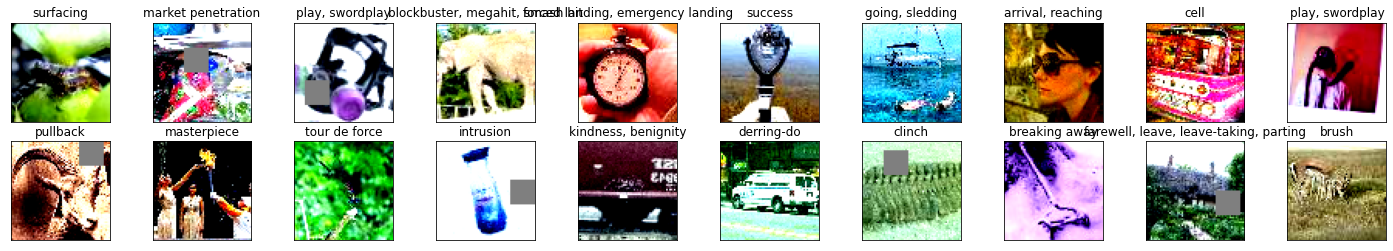

In [9]:
data_iterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(data_iterator, classes=classes)

In [0]:
#import os
#os.chdir('/content/gdrive/My Drive')

In [11]:
!pip install torchsummary
from torchsummary import summary
model = Resnet18_TinyImageNet.ResNet_18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_losses.Test_loss()

# Train and Test the model using ReduceLROnPlateau

**ReduceLROnPlateau-**Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced by 'factor' supplied. 

mode = 'min' means lr will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing.

'min_lr' -> A lower bound on the LR upto which it can be reduced

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH         = 5
L2_factor     = 0.0001
L1_factor     = 0.0005
least_loss_lr = 0.0012

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []

OPTIMIZER = optim.SGD(model.parameters(), lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', factor = 0.1, min_lr=1e-7, patience = 4, verbose=True)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCH):

    print("\nEPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=train_loader,optimizer=OPTIMIZER,
                                                         epoch=EPOCH,factor=L1_factor,criterion=criterion,scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
    test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct = \
                              test_loss.test_loss_calc(model,model.device,test_loader=test_loader, optimizer=OPTIMIZER, total_epoch=EPOCH, 
                                                       current_epoch = epoch,criterion=criterion,scheduler=SCHEDULER)                  
        
    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

    if len(test_loss_all) > 1:
       loss_decrease = 0                  
       loss_decrease = test_loss_all[-2] - test_loss_all[-1]                             
       if loss_decrease > 0:
          print('Test Loss -> Decreasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))     
       else: 
          print('Test Loss -> Increasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))  

  0%|          | 0/301 [00:00<?, ?it/s]


EPOCH: 0


Train Loss = 4.926467418670654 Batch Id = 300 Train Acc = 2.69 LR =0.001200: 100%|██████████| 301/301 [02:42<00:00,  1.85it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Test Accuracy: 5.22, LR : 0.001200

EPOCH: 1


Train Loss = 4.536459922790527 Batch Id = 300 Train Acc = 5.70 LR =0.001200: 100%|██████████| 301/301 [02:42<00:00,  1.85it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Test Accuracy: 7.50, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.018918, Latest Loss: 0.017798, Delta: 0.001120

EPOCH: 2


Train Loss = 4.457442760467529 Batch Id = 300 Train Acc = 8.53 LR =0.001200: 100%|██████████| 301/301 [02:42<00:00,  1.85it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Test Accuracy: 11.14, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.017798, Latest Loss: 0.016659, Delta: 0.001140

EPOCH: 3


Train Loss = 4.026864528656006 Batch Id = 300 Train Acc = 11.22 LR =0.001200: 100%|██████████| 301/301 [02:42<00:00,  1.85it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Test Accuracy: 13.73, LR : 0.001200
Test Loss -> Decreasing, Prev Loss: 0.016659, Latest Loss: 0.015822, Delta: 0.000837

EPOCH: 4


Train Loss = 3.9357075691223145 Batch Id = 300 Train Acc = 13.46 LR =0.001200: 100%|██████████| 301/301 [02:43<00:00,  1.84it/s]


KeyError: ignored

#### Below section of code is to plot **validation accuracy, test loss, training accuracy and train loss** for the all the epochs trained

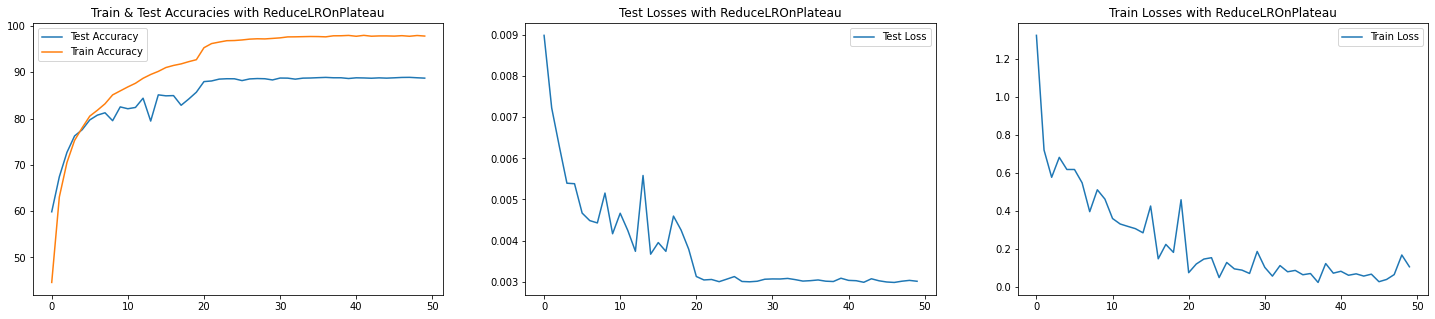

In [0]:
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.0001 & L2=0.0005']

plt.subplot(1,3,1)
plt.title("Train & Test Accuracies with ReduceLROnPlateau")
plt.plot(test_acc_all,label='Test Accuracy')
plt.plot(train_acc_all,label='Train Accuracy')
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.title("Test Losses with ReduceLROnPlateau")
plt.plot(test_loss_all,label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.title("Train Losses with ReduceLROnPlateau")
plt.plot(train_loss_all,label='Train Loss')
plt.legend(loc="best")   